In [1]:
from pathlib import Path
import yaml

from matplotlib.colors import LogNorm
import pandas as pd
import seaborn as sns

## Reconstructions

In [6]:
run_dirs = [p.parent for p in Path('runs').rglob('.hydra')]
len(C), run_dirs[:5]

(180,
 [PosixPath('runs/pku-mmd/all/beta=0.1,latent_dim=32'),
  PosixPath('runs/pku-mmd/all/beta=0.01,latent_dim=16'),
  PosixPath('runs/pku-mmd/all/beta=0.01,latent_dim=128'),
  PosixPath('runs/pku-mmd/all/beta=0,latent_dim=256'),
  PosixPath('runs/pku-mmd/all/beta=0.1,latent_dim=8')])

In [46]:
def read_run_metrics(run_dir):
    params = run_dir / '.hydra' / 'config.yaml'
    with open(params, 'r') as params_file:
        params = yaml.safe_load(params_file)

    log_dir = run_dir / 'lightning_logs' / 'version_0'

    test_metrics = log_dir / 'test_metrics.csv'
    test_metrics = pd.read_csv(test_metrics, index_col=0).squeeze('columns').to_dict()

    checkpoint_dir = log_dir / 'checkpoints' 
    best_checkpoint = next(iter(checkpoint_dir.glob('epoch*.ckpt')))
    best_epoch = int(best_checkpoint.stem.split('-')[0].split('=')[1])

    valid_log = log_dir / 'valid_log.csv'
    valid_log = pd.read_csv(valid_log)

    best_val_epoch = valid_log['val/elbo'].idxmin()
    if best_val_epoch != best_epoch:
        print(f'WARN on {run_dir}: {best_val_epoch=} != {best_epoch=}')

    valid_metrics = valid_log.loc[best_epoch].to_dict()

    return {
        'dataset': run_dir.parts[1],
        'split': run_dir.parts[2],
        'beta': params['beta'],
        'latent_dim': params['latent_dim'],
        'best_epoch': best_epoch,
        **valid_metrics,
        **test_metrics,
    }


In [47]:
metrics = map(read_run_metrics, run_dirs)
metrics = pd.DataFrame(metrics)

WARN on runs/pku-mmd/all/beta=0.1,latent_dim=8: best_val_epoch=61 != best_epoch=58
WARN on runs/pku-mmd/all/beta=10,latent_dim=256: best_val_epoch=501 != best_epoch=49


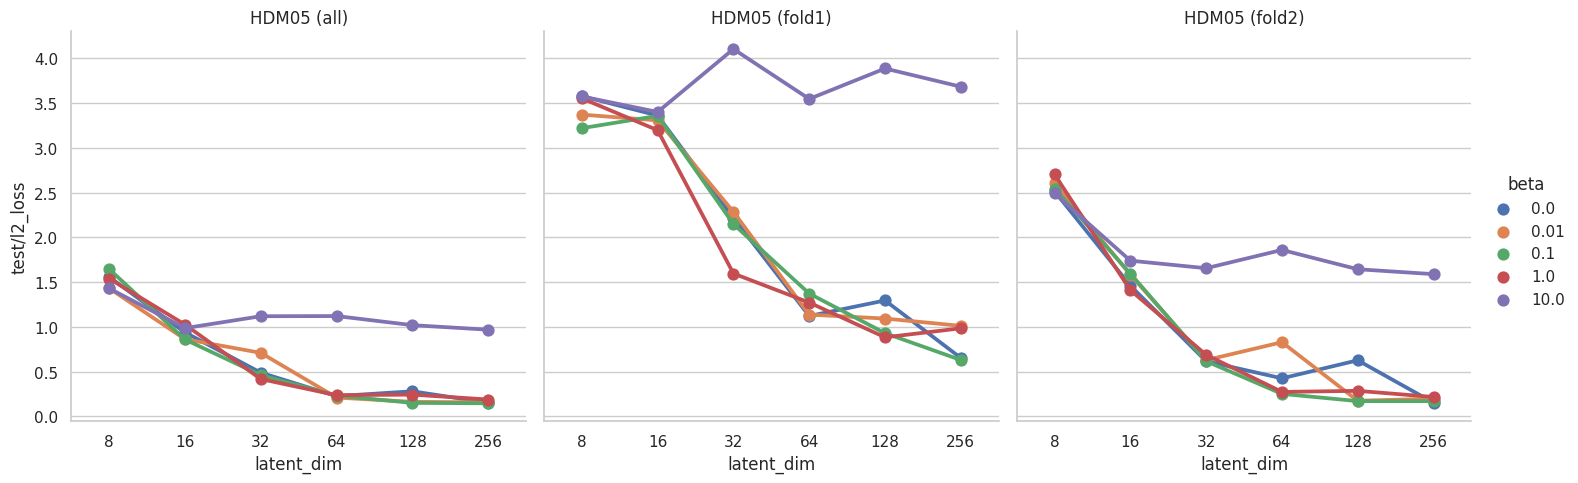

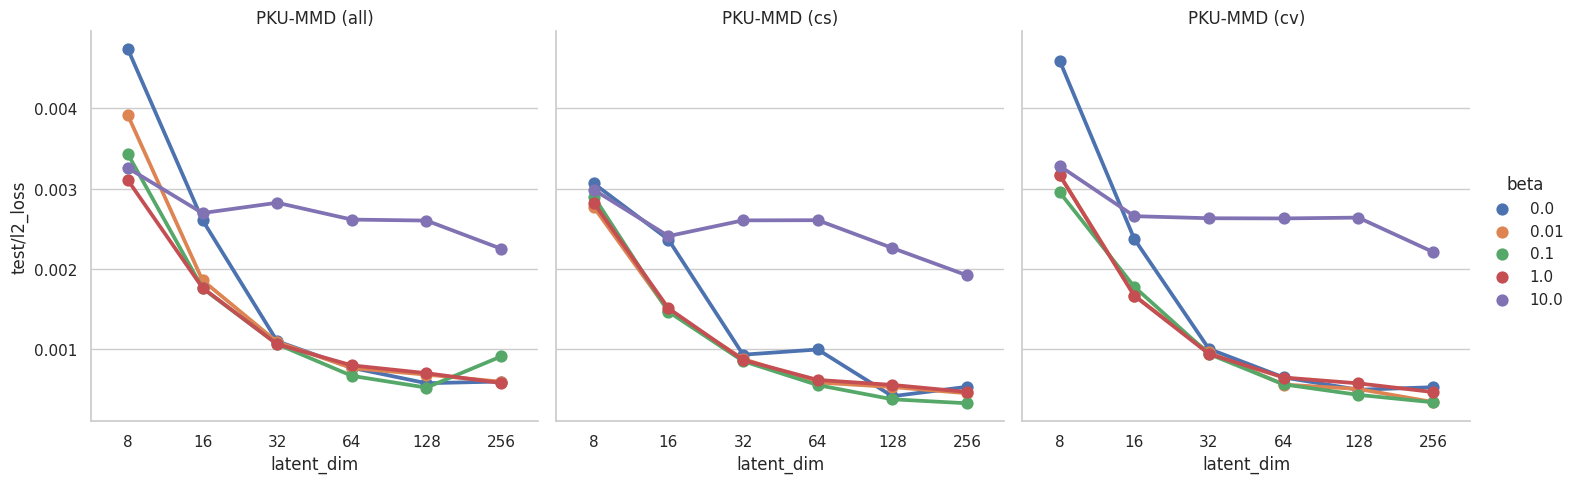

In [77]:
sns.set_theme(style='whitegrid')
for dataset, plot_data in metrics.groupby('dataset'):
    g = sns.catplot(data=plot_data, kind='point', markers='o',
                     col='split', x='latent_dim', y='test/l2_loss',
                     hue='beta', hue_norm=LogNorm())
    g.set_titles(dataset.upper() + ' ({col_name})')

## Retrieval Results

In [13]:
!pip install -qU openpyxl SciencePlots seaborn

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

In [2]:
prec_label = r'Precision@$k$'
acc_label = r'Accuracy@$k$'

def baseline_naming(x):
    # return x.distance.apply(lambda x: fr'Coords, {x} ($L_2$)')
    return "Baseline"

def vae_naming(x):
    # return x.latent_dim.apply(lambda x: fr'$d={x}$') + ', ' + x.distance + r' (cos)'
    return x.latent_dim.apply(lambda x: fr'SCL ($d={x}$)')
    # return x.latent_dim.apply(lambda x: fr'SCL-{x}')

### HDM05 Retrieval

In [3]:
# HDM05 timings baseline
hdm05_timings_baseline = \
    pd.read_excel('exp-VAE_features.xlsx', sheet_name='HDM05-baseline', header=14, nrows=2, usecols='A:D') \
    .drop(0).drop('Unnamed: 0', axis='columns') \
    .rename({'Unnamed: 1': 'UTWn', 'Unnamed: 2': 'DTW', 'Unnamed: 3': 'DTWn'}, axis=1) \
    .melt(var_name='distance', value_name='query_time')

# HDM05 timings VAE
hdm05_timings_vae = \
    pd.read_excel('exp-VAE_features.xlsx', sheet_name='HDM05-retrieval-k50', header=14, nrows=2, usecols='A:G') \
    .drop(0).drop('Unnamed: 0', axis='columns') \
    .melt(var_name='latent_dim', value_name='query_time') \
    .assign(distance='DTWn')

In [4]:
# HDM05 retrieval baseline (Prec@k)
hdm05_retrieval_baseline = \
    pd.read_excel('exp-VAE_features.xlsx', sheet_name='HDM05-baseline', header=18, usecols='A:D') \
    .rename(lambda x: x.replace('ormalized', ''), axis=1) \
    .melt(id_vars='k', var_name='distance') \
    .assign(dataset='HDM05', latent_dim='-', metric=prec_label) \
    .assign(method='Baseline', label=baseline_naming) \
    .merge(hdm05_timings_baseline, how='left', on='distance')
    
# HDM05 VAE retrieval (Prec@K)
hdm05_retrieval_vae = \
    pd.read_excel('exp-VAE_features.xlsx', sheet_name='HDM05-retrieval-k50', header=18, usecols='A:G') \
    .melt(id_vars='k', var_name='latent_dim') \
    .assign(dataset='HDM05', distance='DTWn', metric=prec_label) \
    .assign(method='SCL', label=vae_naming) \
    .merge(hdm05_timings_vae, how='left', on=['latent_dim', 'distance'])

### HDM05 Classification

In [5]:
# HDM05 classification baseline (Accuracy@k)
hdm05_classif_baseline = \
    pd.read_excel('exp-VAE_features.xlsx', sheet_name='HDM05-baseline', header=18, usecols='A,F:H') \
    .rename(lambda x: x.replace('.1', ''), axis=1) \
    .rename(lambda x: x.replace('ormalized', ''), axis=1) \
    .melt(id_vars='k', var_name='distance') \
    .assign(dataset='HDM05', latent_dim='-', metric=acc_label) \
    .assign(method='Baseline', label=baseline_naming) \
    .merge(hdm05_timings_baseline, how='left', on='distance')

# HDM05 VAE classification (Accuracy@K)
hdm05_classif_vae = \
    pd.read_excel('exp-VAE_features.xlsx', sheet_name='HDM05-classif-k50', header=14) \
    .melt(id_vars='k', var_name='latent_dim') \
    .assign(dataset='HDM05', distance='DTWn', metric=acc_label) \
    .assign(method='SCL', label=vae_naming) \
    .merge(hdm05_timings_vae, how='left', on=['latent_dim', 'distance'])

### PKU-MMD Retrieval

In [6]:
# PKU-MMD CV timings baseline
pku_cv_timings_baseline = \
    pd.read_excel('exp-VAE_features.xlsx', sheet_name='PKU-baseline', header=14, nrows=2, usecols='A:D') \
    .drop(0).drop('Unnamed: 0', axis='columns') \
    .rename({'Unnamed: 1': 'UTWn', 'Unnamed: 2': 'DTW', 'Unnamed: 3': 'DTWn'}, axis=1) \
    .melt(var_name='distance', value_name='query_time')

# PKU-MMD CS timings baseline
pku_cs_timings_baseline = \
    pd.read_excel('exp-VAE_features.xlsx', sheet_name='PKU-baseline', header=74, nrows=2, usecols='A:D') \
    .drop(0).drop('Unnamed: 0', axis='columns') \
    .rename({'Unnamed: 1': 'UTWn', 'Unnamed: 2': 'DTW', 'Unnamed: 3': 'DTWn'}, axis=1) \
    .melt(var_name='distance', value_name='query_time')

# PKU-MMD CV timings VAE
pku_cv_timings_vae = \
    pd.read_excel('exp-VAE_features.xlsx', sheet_name='PKU-retrieval-k50', header=14, nrows=2, usecols='A:G') \
    .drop(0).drop('Unnamed: 0', axis='columns') \
    .melt(var_name='latent_dim', value_name='query_time') \
    .assign(distance='DTWn')

# PKU-MMD CS timings VAE
pku_cs_timings_vae = \
    pd.read_excel('exp-VAE_features.xlsx', sheet_name='PKU-retrieval-k50', header=74, nrows=2, usecols='A:G') \
    .drop(0).drop('Unnamed: 0', axis='columns') \
    .melt(var_name='latent_dim', value_name='query_time') \
    .assign(distance='DTWn')

In [7]:
# PKU-MMD CV retrieval baseline (Prec@k)
pku_cv_retrieval_baseline = \
    pd.read_excel('exp-VAE_features.xlsx', sheet_name='PKU-baseline', header=18, usecols='A:D', nrows=50) \
    .rename(lambda x: x.replace('ormalized', ''), axis=1) \
    .melt(id_vars='k', var_name='distance') \
    .assign(dataset='PKU-MMD (CV)', latent_dim='-', metric=prec_label) \
    .assign(method='Baseline', label=baseline_naming) \
    .merge(pku_cv_timings_baseline, how='left', on='distance')

# PKU-MMD CS retrieval baseline (Prec@k)
pku_cs_retrieval_baseline = \
    pd.read_excel('exp-VAE_features.xlsx', sheet_name='PKU-baseline', header=78, usecols='A:D') \
    .rename(lambda x: x.replace('ormalized', ''), axis=1) \
    .melt(id_vars='k', var_name='distance') \
    .assign(dataset='PKU-MMD (CS)', method='Coords', latent_dim='-', metric=prec_label) \
    .assign(method='Baseline', label=baseline_naming) \
    .merge(pku_cs_timings_baseline, how='left', on='distance')

# PKU-MMD CV retrieval vae (Prec@k)
pku_cv_retrieval_vae = \
    pd.read_excel('exp-VAE_features.xlsx', sheet_name='PKU-retrieval-k50', header=18, nrows=50, usecols='A:G') \
    .melt(id_vars='k', var_name='latent_dim') \
    .assign(dataset='PKU-MMD (CV)', distance='DTWn', metric=prec_label) \
    .assign(method='SCL', label=vae_naming) \
    .merge(pku_cv_timings_vae, how='left', on=['latent_dim', 'distance'])

# PKU-MMD CS retrieval vae (Prec@k)
pku_cs_retrieval_vae = \
    pd.read_excel('exp-VAE_features.xlsx', sheet_name='PKU-retrieval-k50', header=78, usecols='A:G') \
    .melt(id_vars='k', var_name='latent_dim') \
    .assign(dataset='PKU-MMD (CS)', distance='DTWn', metric=prec_label) \
    .assign(method='SCL', label=vae_naming) \
    .merge(pku_cs_timings_vae, how='left', on=['latent_dim', 'distance'])

### PKU-MMD Classification

In [8]:
# PKU-MMD CV classif baseline (Acc@k)
pku_cv_classif_baseline = \
    pd.read_excel('exp-VAE_features.xlsx', sheet_name='PKU-baseline', header=18, usecols='A,F:H', nrows=50) \
    .rename(lambda x: x.replace('ormalized', ''), axis=1) \
    .rename(lambda x: x.replace('.1', ''), axis=1) \
    .melt(id_vars='k', var_name='distance') \
    .assign(dataset='PKU-MMD (CV)', latent_dim='-', metric=acc_label) \
    .assign(method='Baseline', label=baseline_naming) \
    .merge(pku_cv_timings_baseline, how='left', on='distance')

# PKU-MMD CS classif baseline (Acc@k)
pku_cs_classif_baseline = \
    pd.read_excel('exp-VAE_features.xlsx', sheet_name='PKU-baseline', header=78, usecols='A,F:H') \
    .rename(lambda x: x.replace('ormalized', ''), axis=1) \
    .rename(lambda x: x.replace('.1', ''), axis=1) \
    .melt(id_vars='k', var_name='distance') \
    .assign(dataset='PKU-MMD (CS)', latent_dim='-', metric=acc_label) \
    .assign(method='Baseline', label=baseline_naming) \
    .merge(pku_cs_timings_baseline, how='left', on='distance')

# PKU-MMD CV VAE classification (Accuracy@K)
pku_cv_classif_vae = \
    pd.read_excel('exp-VAE_features.xlsx', sheet_name='PKU-classif-k50', header=14, nrows=50) \
    .melt(id_vars='k', var_name='latent_dim') \
    .assign(dataset='PKU-MMD (CV)', distance='DTWn', metric=acc_label) \
    .assign(method='SCL', label=vae_naming) \
    .merge(pku_cv_timings_vae, how='left', on=['latent_dim', 'distance'])

# PKU-MMD CS VAE classification (Accuracy@K)
pku_cs_classif_vae = \
    pd.read_excel('exp-VAE_features.xlsx', sheet_name='PKU-classif-k50', header=70) \
    .melt(id_vars='k', var_name='latent_dim') \
    .assign(dataset='PKU-MMD (CS)', distance='DTWn', metric=acc_label) \
    .assign(method='SCL', label=vae_naming) \
    .merge(pku_cs_timings_vae, how='left', on=['latent_dim', 'distance'])

In [9]:
baselines = (
    hdm05_retrieval_baseline,
    hdm05_classif_baseline,
    pku_cv_retrieval_baseline,
    pku_cs_retrieval_baseline,
    pku_cv_classif_baseline,
    pku_cs_classif_baseline,
)

vae = (
    hdm05_retrieval_vae,
    hdm05_classif_vae,
    pku_cv_retrieval_vae,
    pku_cs_retrieval_vae,
    pku_cv_classif_vae,
    pku_cs_classif_vae,
)

## Effectiveness vs K

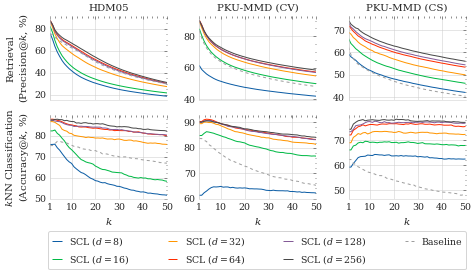

In [10]:
sns.set_theme(context='notebook', style='whitegrid', font_scale=0.85)
plt.style.use(['science','no-latex'])

baseline = pd.concat(baselines, ignore_index=True)
baseline = baseline[baseline.distance == 'DTW']  # best distance for baseline

data = pd.concat((*vae, baseline), ignore_index=True)

dashes = {k: (3, 3) if 'Baseline' in k else (1, 0) for k in data.label.unique()}
# data = data[data.k.isin((1, 2, 3, 4, 5, 10, 15, 20, 25))]
g = sns.relplot(
    data=data, kind='line', #marker='o', ms=3,
    row='metric', col='dataset',
    x='k', y='value', hue='label',
    style='label', dashes=dashes,
    aspect=1.4, height=1.7,
    facet_kws=dict(
        margin_titles=True,
        sharey=False,
    ),
)

g.set_titles(col_template='{col_name}', row_template='')
g.set_axis_labels(x_var=r'$k$', y_var='%')
g.set(xlim=(1, 50), xticks=(1, 10, 20, 30, 40, 50))

g.axes[0,0].set_ylabel(f'Retrieval\n({prec_label}, %)')
g.axes[1,0].set_ylabel(f'$k$NN Classification\n({acc_label}, %)')

sns.move_legend(g, loc='lower center', ncol=4, mode='expand', bbox_to_anchor=(0.083, -0.15, 0.695, 1),
                handlelength=1, frameon=True)#, facecolor=(.9,.9,.9,1))
g.legend.set_title('')
g.tight_layout()

g.savefig('figures/perf-vs-k.pdf', bbox_inches='tight')

## Effectiveness vs Efficiency

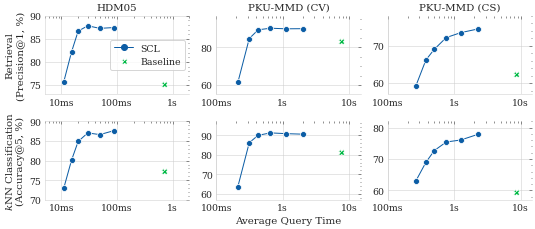

In [11]:
sns.set_theme(context='notebook', style='whitegrid', font_scale=0.85)
plt.style.use(['science','no-latex'])

baseline = pd.concat(baselines, ignore_index=True)
baseline = baseline[baseline.distance == 'DTW']  # best distance for baseline

data = pd.concat((*vae, baseline), ignore_index=True)

keep = ((data.k == 1) & data.metric.str.contains('Precision')) | ((data.k == 5) & data.metric.str.contains('Accuracy'))
data = data[keep]
# data['method'] = data.method.apply(lambda x: f'{x}, DTWn' if 'SCL' in x else f'{x}, DTW')

g = sns.relplot(
    data=data, kind='line',
    row='metric', col='dataset',
    x='query_time', y='value', 
    hue='method', style='method', markers=True,
    aspect=1.5, height=1.7,
    facet_kws=dict(
        margin_titles=True,
        sharey=False,
        sharex=False,
        legend_out=False,
    ),
)

g.set_titles(col_template='{col_name}', row_template='')
g.set_axis_labels(x_var='Average Query Time', y_var='')

g.axes[1,0].set_xlabel('')
g.axes[1,2].set_xlabel('')

g.axes[0,0].set_ylabel(f'Retrieval\n(Precision@1, %)')
g.axes[1,0].set_ylabel(f'$k$NN Classification\n(Accuracy@5, %)')
g.legend.set_title('')
g.legend.draw_frame(True)
g.legend.get_frame().set_facecolor('white')
c = g.legend.legendHandles[1].get_mfc()
g.legend.legendHandles[1].set_color('white')
g.legend.legendHandles[1].set_mec('white')
g.legend.legendHandles[1].set_mfc(c)

g.set(xscale='log', xticks=(10, 100, 1_000, 10_000), xticklabels=('10ms', '100ms', '1s', '10s'))

g.axes[0,0].set_xlim(5, 2_000)
g.axes[1,0].set_xlim(5, 2_000)

g.axes[0,1].set_xlim(100, 15_000)
g.axes[1,1].set_xlim(100, 15_000)

g.axes[0,2].set_xlim(100, 15_000)
g.axes[1,2].set_xlim(100, 15_000)

g.axes[0,0].set_ylim(73, 90)
g.axes[1,0].set_ylim(70, 90)

g.axes[0,1].set_ylim(55, 97)
g.axes[1,1].set_ylim(57, 97)

g.axes[0,2].set_ylim(57, 78)
g.axes[1,2].set_ylim(57, 82)

g.tight_layout()
g.savefig('figures/perf-vs-time.pdf', bbox_inches='tight')

In [12]:
tmp = data.copy()
tmp = tmp[tmp.latent_dim.isin((256, '-')) & (tmp.metric == 'Precision@$k$')]
tmp['value'] = tmp.value.apply(lambda x: f'{x:.2f}\%')
tmp = tmp.value.iloc[:3].values + ' vs ' + tmp.value.iloc[3:].values + ' on ' + tmp.dataset.iloc[:3]
print(tmp.str.cat(sep=', '))

87.42\% vs 75.22\% on HDM05, 90.03\% vs 83.58\% on PKU-MMD (CV), 74.41\% vs 62.34\% on PKU-MMD (CS)
